**Sentiment Analysis and Drug Review Insights: A Data-Driven Approach to Understanding User Feedback**

**INTRODUCTION**

Welcome to the Sentiment Analysis and Drug Review Insights project! In this project, we explore thousands of user reviews to better understand public sentiment regarding various drugs. By leveraging natural language processing (NLP) techniques and machine learning models, we aim to analyze text data, classify sentiments, and extract key insights from these reviews.

What to Expect in This Project:
- Data Exploration & Preprocessing: We begin by cleaning the data, which includes removing unnecessary characters, handling missing values, and preparing the text for analysis (e.g., lemmatization and stopword removal).

- Sentiment Analysis: Using tools like TextBlob, we calculate sentiment scores for each review and categorize them into Positive, Negative, or Neutral sentiments.

- Exploratory Data Analysis (EDA): We visualize patterns within the drug reviews, such as sentiment distribution, top-reviewed drugs, and rating trends, to understand the key factors influencing user opinions.

- Machine Learning Models: Several machine learning models (Logistic Regression, Decision Tree, Random Forest) are built and evaluated to predict the sentiment of a review based on its text.

- Topic Modeling: With Latent Dirichlet Allocation (LDA), we identify the most common topics discussed in the reviews, including side effects, drug effectiveness, and overall user experiences.

Why This Matters:
Understanding user feedback on drugs is critical for healthcare providers, pharmaceutical companies, and patients. This project helps uncover common themes and opinions, providing actionable insights into drug performance, potential side effects, and overall satisfaction. The goal is to bridge the gap between patient experiences and the insights that healthcare professionals need to improve drug outcomes.

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from matplotlib import style
style.use('ggplot')
from nltk.corpus import stopwords
import re
from textblob import TextBlob
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
import warnings
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

**Loading the Dataset**

In [20]:
df = pd.read_csv(r'C:\Users\PC\Desktop\Datasets\drug_review_test.csv')

In [23]:
#displaying the first five rows of the DataFrame
df.head()

Unnamed: 0  patient_id         drugName                     condition  \
0           0      163740      Mirtazapine                    depression   
1           1      206473       Mesalamine  crohn's disease, maintenance   
2           2       39293         Contrave                   weight loss   
3           3       97768  Cyclafem 1 / 35                 birth control   
4           4      208087          Zyclara                     keratosis   

                                              review  rating  \
0  "i've tried a few antidepressants over the yea...    10.0   
1  "my son has crohn's disease and has done very ...     8.0   
2  "contrave combines drugs that were used for al...     9.0   
3  "i have been on this birth control for one cyc...     9.0   
4  "4 days in on first 2 weeks.  using on arms an...     4.0   

                date  usefulCount  review_length  
0  February 28, 2012           22             68  
1       May 17, 2009           17             48  
2      March 5, 2017           35            143  
3   October 22, 2015            4            149  
4       July 3, 2014           13             60

***Exploratory Data Analysis***

In [50]:
# Counting the frequency of each condition in the 'condition' column
df['condition'].value_counts()

condition
birth control                                                     9257
depression                                                        2761
acne                                                              1724
pain                                                              1590
anxiety                                                           1589
bipolar disorde                                                   1151
weight loss                                                       1139
obesity                                                           1075
insomnia                                                          1004
adhd                                                               978
emergency contraception                                            783
vaginal yeast infection                                            729
diabetes, type 2                                                   687
high blood pressure                                                

In [25]:
# Group the data by drugName and condition, and count the number of reviews for each
pd.set_option('display.max_rows', None)

drug_condition_counts = df.groupby(['drugName', 'condition']).size().reset_index(name='review_count')

# Display the first few rows of the grouped data
drug_condition_counts.head(10)

drugName  \
0                            A / B Otic   
1  Abacavir / dolutegravir / lamivudine   
2                 Abacavir / lamivudine   
3                             Abatacept   
4                               Abilify   
5                               Abilify   
6                               Abilify   
7                               Abilify   
8                               Abilify   
9                               Abilify   

                                     condition  review_count  
0                                 otitis media             1  
1                                hiv infection            16  
2                                hiv infection             2  
3                         rheumatoid arthritis             4  
4  20</span> users found this comment helpful.             1  
5                               agitated state             1  
6                                       autism             2  
7                              bipolar disorde            39  
8                                   depression            39  
9                     major depressive disorde            14

**Top 10 Drugs by Review Count Across Conditions**

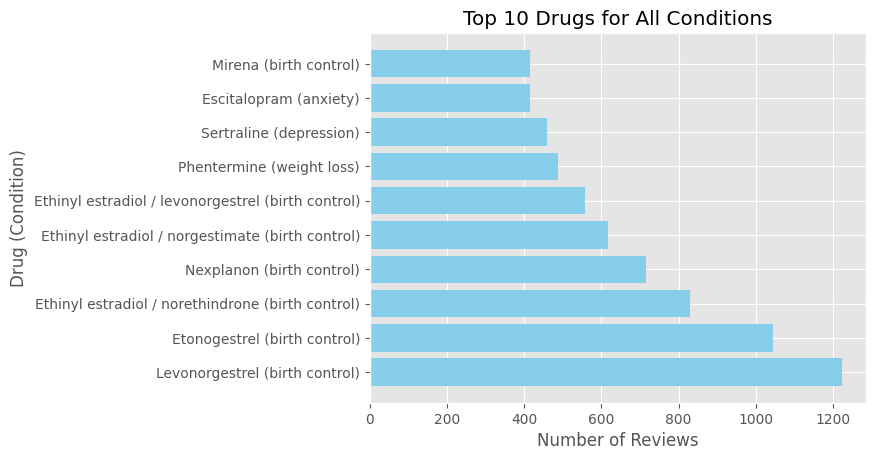

In [26]:
# Group the data by drugName and condition, count the number of reviews, and unstack
drug_condition = df.groupby(['drugName', 'condition']).size().unstack().fillna(0)

# Calculate total number of reviews for each drug (across all conditions)
drug_condition_sums = drug_condition.sum(axis=1)

# Get the top 10 drugs by total number of reviews
top_10_drugs = drug_condition_sums.nlargest(10)

# Create a DataFrame with the drug name and corresponding condition (add the condition back for understanding)
# We take the condition with the maximum reviews for each drug
top_10_drug_conditions = pd.DataFrame({
    'drug': top_10_drugs.index, 
    'condition': drug_condition.idxmax(axis=1).loc[top_10_drugs.index],  # Condition with most reviews for each drug
    'review_count': top_10_drugs.values
})

# Create the bar plot with drug names and corresponding conditions
plt.barh(top_10_drug_conditions['drug'] + ' (' + top_10_drug_conditions['condition'] + ')', 
         top_10_drug_conditions['review_count'], color='skyblue')

# Set the title and labels
plt.title('Top 10 Drugs for All Conditions')
plt.xlabel('Number of Reviews')
plt.ylabel('Drug (Condition)')
plt.show()

Observation
- This chart shows that birth control, mental health treatments, and weight loss medications are the most reviewed.

**Rating Distribution of Drug Reviews**

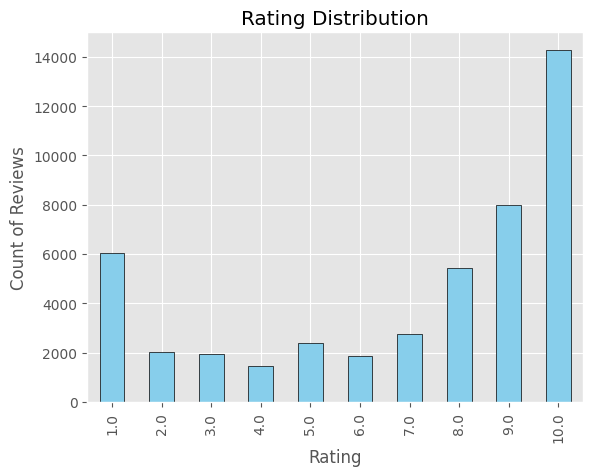

In [9]:
# Bar chart for rating distribution
df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count of Reviews')
plt.show()

Observation
- The bar chart shows the number of reviews for different ratings, ranging from 1.0 to 10.0. The highest number of reviews is for the rating of 10.0, with nearly 14,000 reviews, indicating a strong preference for this rating among users. The next highest is for the rating of 9.0, while ratings from 1.0 to 8.0 have significantly fewer reviews, all under approximately half the count of the 9.0 rating or less. This distribution suggests that the majority of users have had very positive experiences, as evidenced by the high number of top ratings.

**Top 10 Drugs by Number of Reviews**

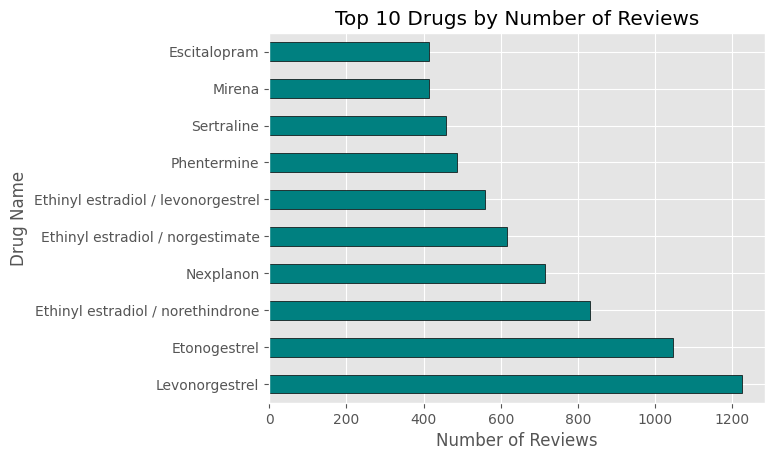

In [11]:
# Top 10 drugs with the most reviews
top_10_drugs = df['drugName'].value_counts().nlargest(10)

# Plot the horizontal bar chart
top_10_drugs.plot(kind='barh', color='teal', edgecolor='black')
plt.title('Top 10 Drugs by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Drug Name')
plt.show()

Observation
- The bar chart titled “Top 10 Drugs by Number of Reviews” shows the most reviewed medications, with Escitalopram and Mirena leading the list. The chart highlights the popularity and user engagement with these drugs, indicating their widespread use and the significant number of reviews they have received. 

**Scatter Plot of Useful Count vs Rating**

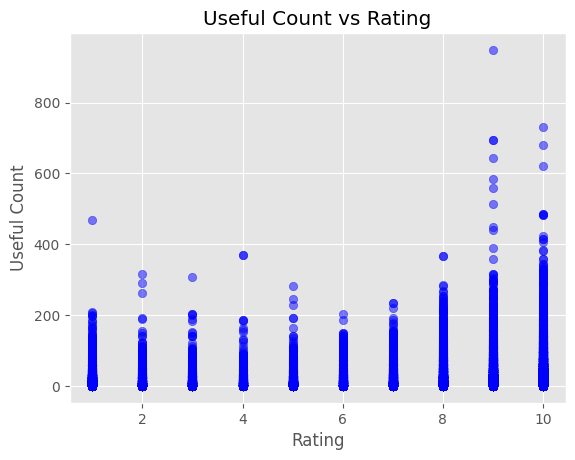

In [13]:
# Scatter plot of usefulCount vs rating
plt.scatter(df['rating'], df['usefulCount'], alpha=0.5, color='blue')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.grid(True)
plt.show()

**Review Length Distribution**

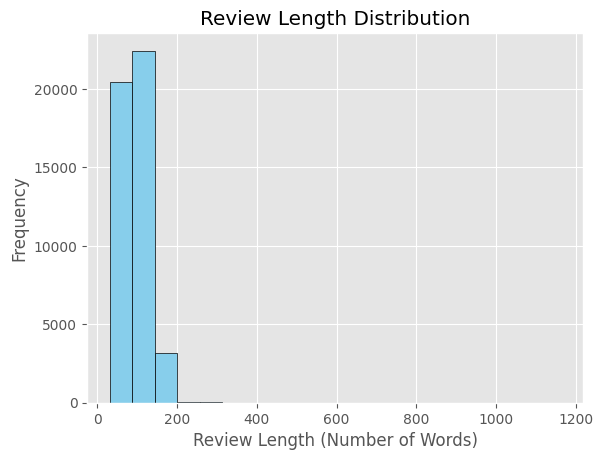

In [17]:
# Plotting the distribution of review lengths (number of words in each review)
df['review_length'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Review Length Distribution')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

Observation
- This histogram shows that most reviews are short, with fewer reviews as the word count increases

**Sentiment Analysis of Reviews**

In [27]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Returns a score between -1 (negative) and 1 (positive)

df['sentiment_score'] = df['review'].apply(get_sentiment)

# Classify into positive, negative, and neutral
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

In [28]:
df.head()

Unnamed: 0  patient_id         drugName                     condition  \
0           0      163740      Mirtazapine                    depression   
1           1      206473       Mesalamine  crohn's disease, maintenance   
2           2       39293         Contrave                   weight loss   
3           3       97768  Cyclafem 1 / 35                 birth control   
4           4      208087          Zyclara                     keratosis   

                                              review  rating  \
0  "i've tried a few antidepressants over the yea...    10.0   
1  "my son has crohn's disease and has done very ...     8.0   
2  "contrave combines drugs that were used for al...     9.0   
3  "i have been on this birth control for one cyc...     9.0   
4  "4 days in on first 2 weeks.  using on arms an...     4.0   

                date  usefulCount  review_length  sentiment_score sentiment  
0  February 28, 2012           22             68         0.000000   neutral  
1       May 17, 2009           17             48         0.566667  positive  
2      March 5, 2017           35            143         0.139063  positive  
3   October 22, 2015            4            149         0.260926  positive  
4       July 3, 2014           13             60         0.341667  positive

**Sentiment Distribution of Reviews**

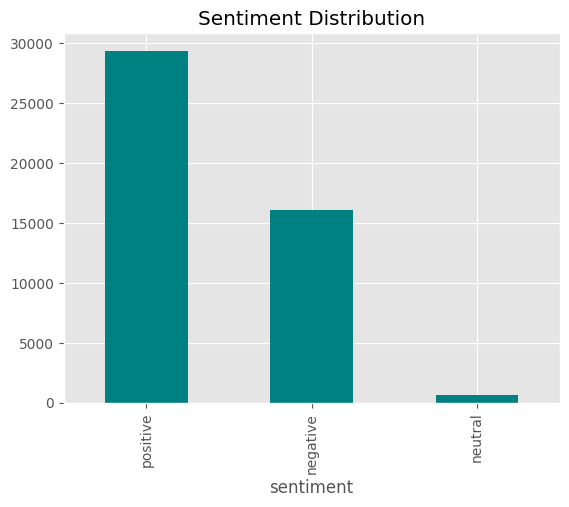

In [31]:
import matplotlib.pyplot as plt
df['sentiment'].value_counts().plot(kind='bar', color='teal', title='Sentiment Distribution')
plt.show()

Observation
- This bar chart shows that positive sentiments are the most common, followed by negative and neutral sentiments.

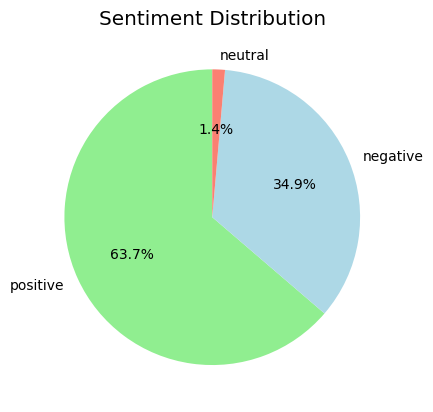

In [32]:
sentiment_counts = df['sentiment'].value_counts()

# Plot a pie chart
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightblue', 'salmon'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()

Observation
- This pie chart shows that 63.7% of sentiments are positive, 34.9% are negative, and 1.4% are neutral.

<Axes: >

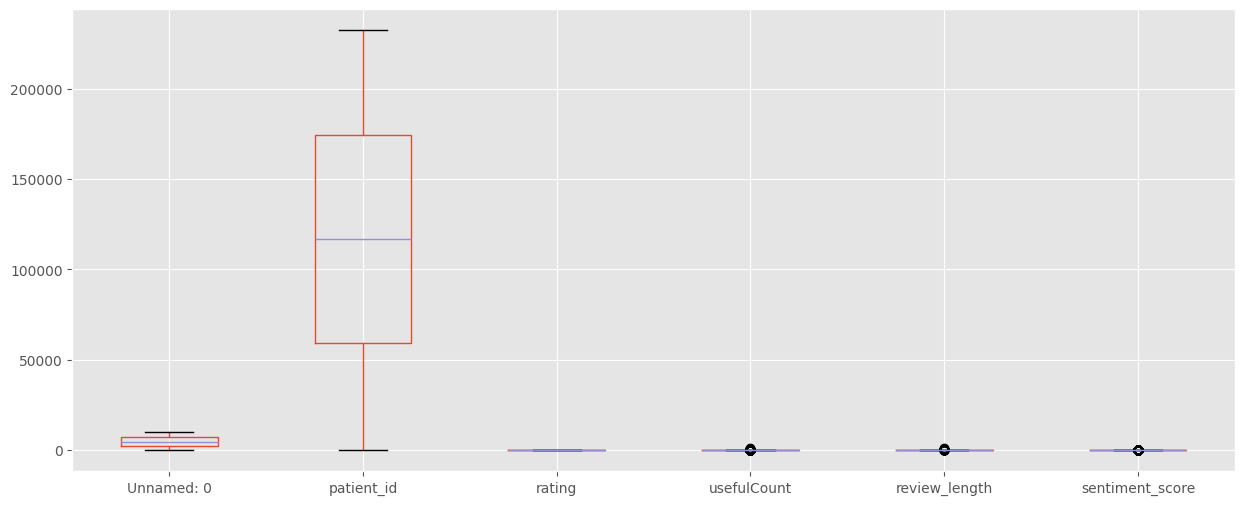

In [36]:
df.boxplot(figsize=(15,6))

Observation
- The boxplot shows significant variability in patient_id but limited variation in features like usefulCount, review_length, and sentiment_score, which are heavily skewed towards lower values. This suggests most reviews are short and not frequently marked as useful, with few outliers. 

 **Review trends overtime**

In [38]:
df['date'] = pd.to_datetime(df['date'])

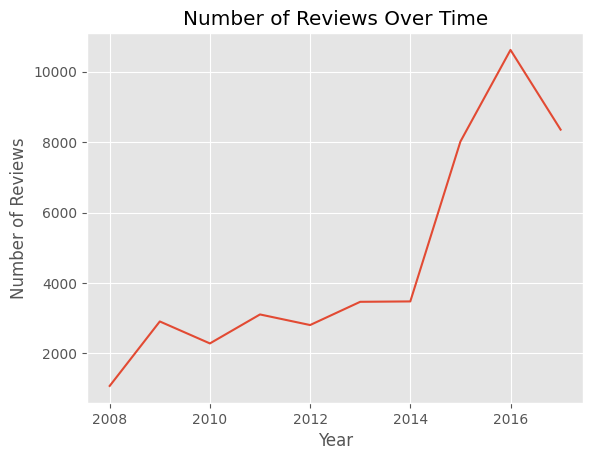

In [39]:
reviews_per_year = df.groupby(df['date'].dt.year).size()
reviews_per_year.plot(kind='line', title='Number of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

Observation
- This line graph shows a significant increase in the number of reviews over time, peaking sharply around 2016.

**Sentiment Overtime**

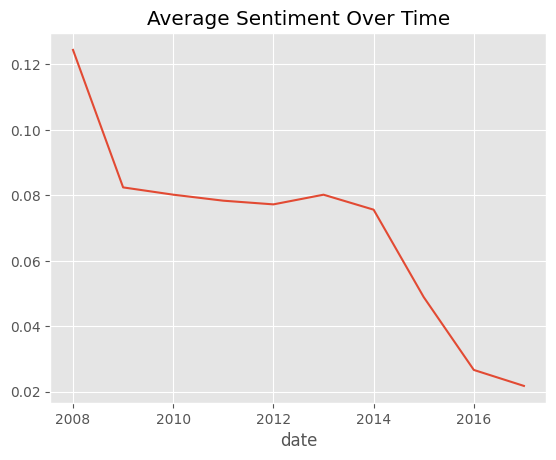

In [40]:
sentiment_per_year = df.groupby(df['date'].dt.year)['sentiment_score'].mean()
sentiment_per_year.plot(kind='line', title='Average Sentiment Over Time')
plt.show()

Observation
- The Average Sentiment Over Time illustrates a downward trend in sentiment from 2008 to 2016. Starting just above 0.1 in 2008, the sentiment steadily declines, reaching just above 0.02 by 2016. This suggests a significant negative shift in opinions or attitudes over the eight-year period.

**Heatmap: Correlation Between Numerical Features**

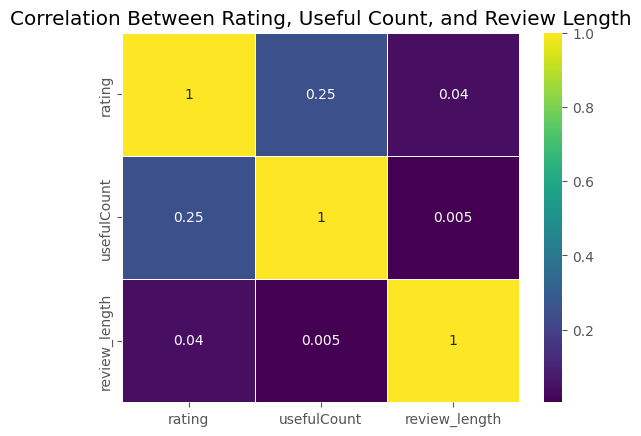

In [46]:
correlation_matrix = df[['rating', 'usefulCount', 'review_length']].corr()

# Plot a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Between Rating, Useful Count, and Review Length')
plt.show()

In [48]:
# Check for missing values in each column
df.isna().sum()

Unnamed: 0         0
patient_id         0
drugName           0
condition          0
review             0
rating             0
date               0
usefulCount        0
review_length      0
sentiment_score    0
sentiment          0
dtype: int64

**Text Preprocessing: Removing Special Characters, Lowercasing, Stopwords, Lemmatization, and Vectorization**

In [52]:
# Initializing the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean a single review
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation and non-alphabetical characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize and remove stopwords, then lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a single string
    return ' '.join(tokens)

#cleaning the column containing the reviews
df['cleaned_reviews'] = df['review'].apply(clean_text)

# Now, 'cleaned_reviews' contains the preprocessed reviews
cleaned_reviews = df['cleaned_reviews'].tolist()

# Apply CountVectorizer on the cleaned reviews
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
review_matrix = vectorizer.fit_transform(cleaned_reviews)

print(review_matrix.shape)

(46108, 18205)


**Modeling with Latent Dirichlet Allocation (LDA)**

In [54]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)  # n_components is the number of topics
lda.fit(review_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [56]:
#Displaying LDA Topics with Top Words
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic 0:
['mg', 'day', 'anxiety', 'effect', 'feel', 'taking', 'year', 'week', 'im', 'started']
Topic 1:
['day', 'effect', 'time', 'year', 'taking', 'hour', 'blood', 'took', 'doctor', 'like']
Topic 2:
['day', 'week', 'skin', 'month', 'acne', 'got', 'period', 'im', 'year', 'like']
Topic 3:
['pain', 'day', 'year', 'taking', 'work', 'time', 'mg', 'doctor', 'effect', 'medication']
Topic 4:
['month', 'period', 'pill', 'ive', 'im', 'control', 'weight', 'birth', 'day', 'week']


Observation
- The LDA  modeling reveals key themes in drug reviews, including anxiety treatment, medication effects, skin conditions, pain management, and birth control, offering insights into common user concerns and experiences with their treatments.

In [58]:
## Mapping sentiment categories to numerical values: neutral = 1, negative = 0, positive = 2
df['target'] = df['sentiment'].map({'neutral': 1, 'negative': 0, 'positive': 2})

In [59]:
df.head()

Unnamed: 0  patient_id         drugName                     condition  \
0           0      163740      Mirtazapine                    depression   
1           1      206473       Mesalamine  crohn's disease, maintenance   
2           2       39293         Contrave                   weight loss   
3           3       97768  Cyclafem 1 / 35                 birth control   
4           4      208087          Zyclara                     keratosis   

                                              review  rating       date  \
0  "i've tried a few antidepressants over the yea...    10.0 2012-02-28   
1  "my son has crohn's disease and has done very ...     8.0 2009-05-17   
2  "contrave combines drugs that were used for al...     9.0 2017-03-05   
3  "i have been on this birth control for one cyc...     9.0 2015-10-22   
4  "4 days in on first 2 weeks.  using on arms an...     4.0 2014-07-03   

   usefulCount  review_length  sentiment_score sentiment  \
0           22             68         0.000000   neutral   
1           17             48         0.566667  positive   
2           35            143         0.139063  positive   
3            4            149         0.260926  positive   
4           13             60         0.341667  positive   

                                     cleaned_reviews  target  
0  ive tried antidepressant year citalopram fluox...       1  
1  son crohn disease done well asacol complaint s...       2  
2  contrave combine drug used alcohol smoking opi...       2  
3  birth control one cycle reading review type si...       2  
4  day first week using arm face put vaseline lip...       2

*Filtering Positive Reviews*

In [60]:
pos_reviews = df[df.target==2]
pos_reviews.head()

Unnamed: 0  patient_id         drugName                     condition  \
1           1      206473       Mesalamine  crohn's disease, maintenance   
2           2       39293         Contrave                   weight loss   
3           3       97768  Cyclafem 1 / 35                 birth control   
4           4      208087          Zyclara                     keratosis   
6           6      169852    Amitriptyline           migraine prevention   

                                              review  rating       date  \
1  "my son has crohn's disease and has done very ...     8.0 2009-05-17   
2  "contrave combines drugs that were used for al...     9.0 2017-03-05   
3  "i have been on this birth control for one cyc...     9.0 2015-10-22   
4  "4 days in on first 2 weeks.  using on arms an...     4.0 2014-07-03   
6  "this has been great for me. i've been on it f...     9.0 2009-04-21   

   usefulCount  review_length  sentiment_score sentiment  \
1           17             48         0.566667  positive   
2           35            143         0.139063  positive   
3            4            149         0.260926  positive   
4           13             60         0.341667  positive   
6           32             64         0.185417  positive   

                                     cleaned_reviews  target  
1  son crohn disease done well asacol complaint s...       2  
2  contrave combine drug used alcohol smoking opi...       2  
3  birth control one cycle reading review type si...       2  
4  day first week using arm face put vaseline lip...       2  
6  great ive week last week headache went away ty...       2

*Positive Wordcloud Vizualization*

Text(0.5, 1.0, 'Most Frequently Used Words In Positive Review')

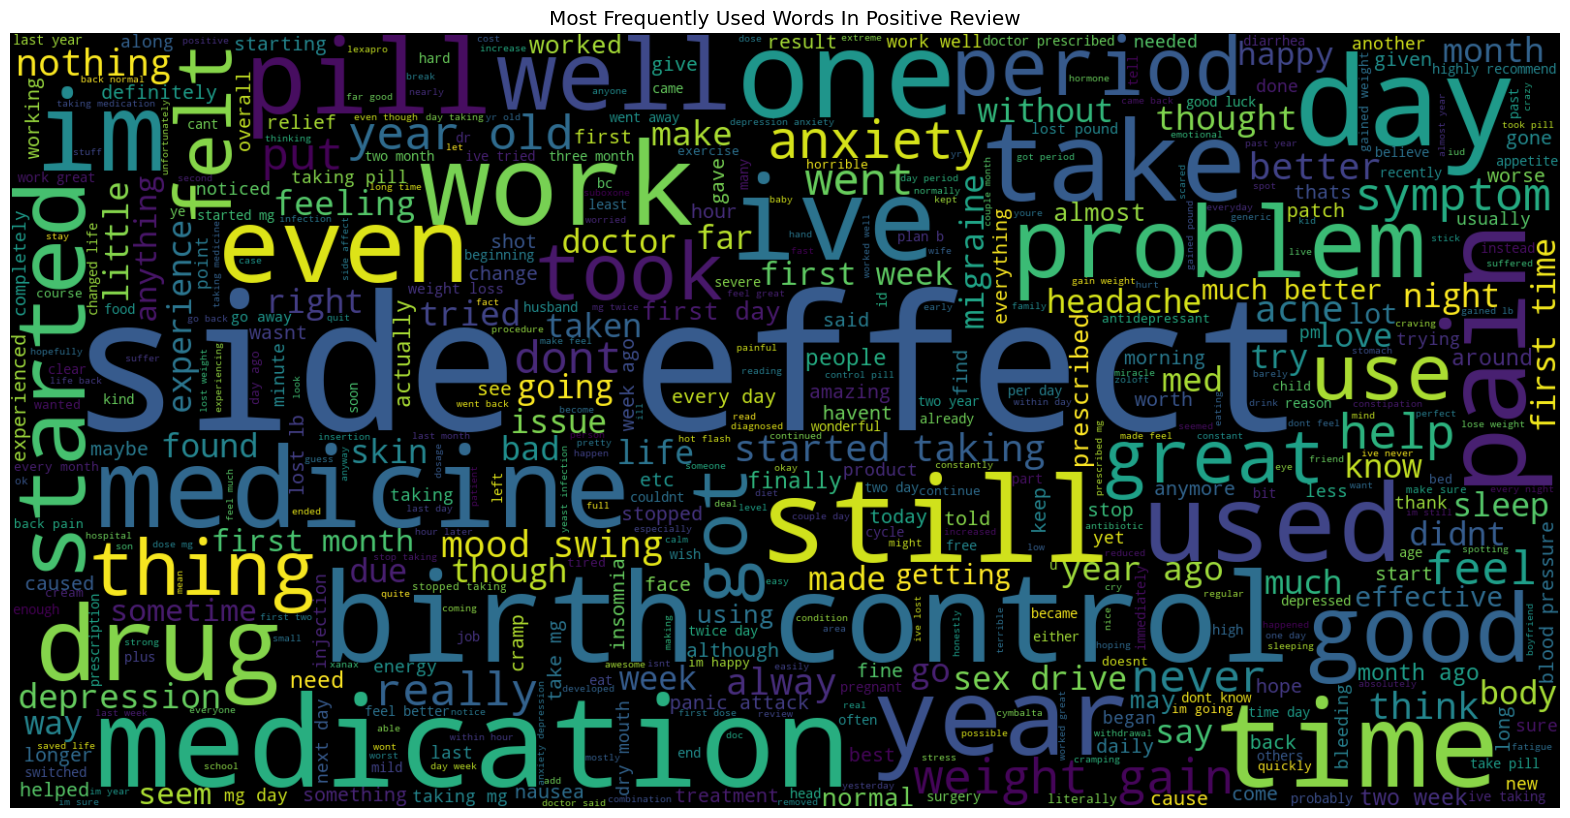

In [69]:
text = ' '.join([word for word in pos_reviews['cleaned_reviews']])
plt.figure(figsize=(20,60), facecolor=None)
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequently Used Words In Positive Review')

Observation
- The word cloud highlights key terms in positive reviews, with "side effect," "birth control," "still," "medication," and "drug" standing out prominently. This suggests that while users are discussing medication positively, side effects and birth control are recurring themes in their experiences. Other notable terms like "take," "pain," "work," and "time" reflect common concerns or observations about the efficacy and usage of these medications.

*Negative Wordcloud Vizualization*

In [63]:
neg_reviews = df[df.target==0]

Text(0.5, 1.0, 'Most Frequently Used Words In Negative Review')

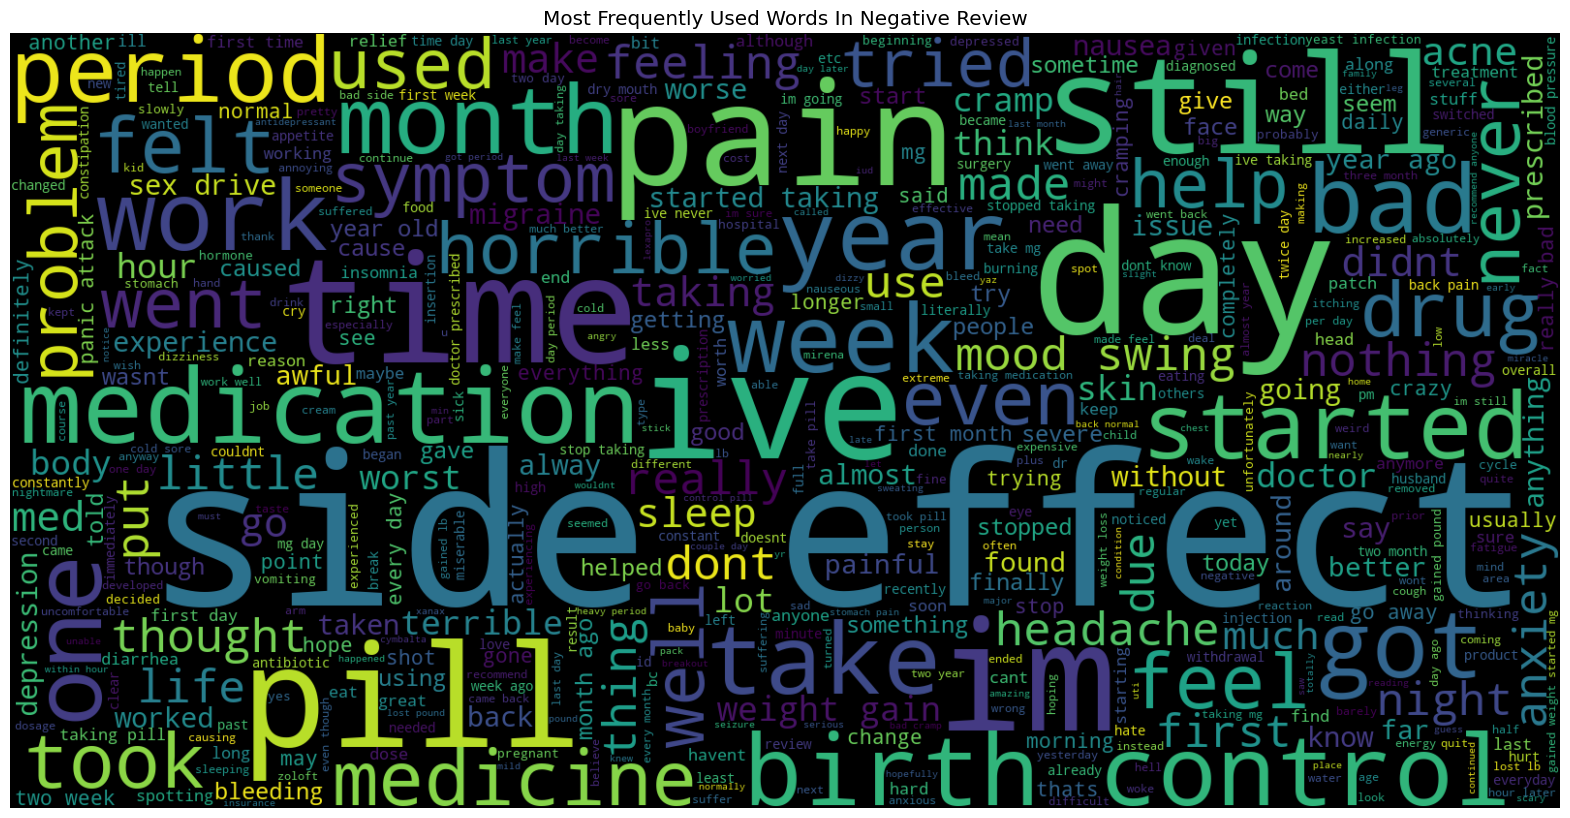

In [68]:
text = ' '.join([word for word in neg_reviews['cleaned_reviews']])
plt.figure(figsize=(20,60), facecolor=None)
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequently Used Words In Negative Review')

Observation
- The word cloud for negative reviews highlights "side effect," "pain," "medication," "still," and "pill" as the most frequent terms, indicating that side effects and pain are major concerns in users' negative experiences with medications. Words like "anxiety," "horrible," "bad," "issue," and "problem" suggest dissatisfaction with both the medication's effectiveness and the adverse effects experienced. The prominence of terms such as "year," "month," and "day" may indicate a focus on the duration of use and the long-term impact of these side effects. 

*Neutral Wordcloud Vizualization*

In [65]:
neu_reviews = df[df.target==0]

Text(0.5, 1.0, 'Most Frequently Used Words In Neutral Review')

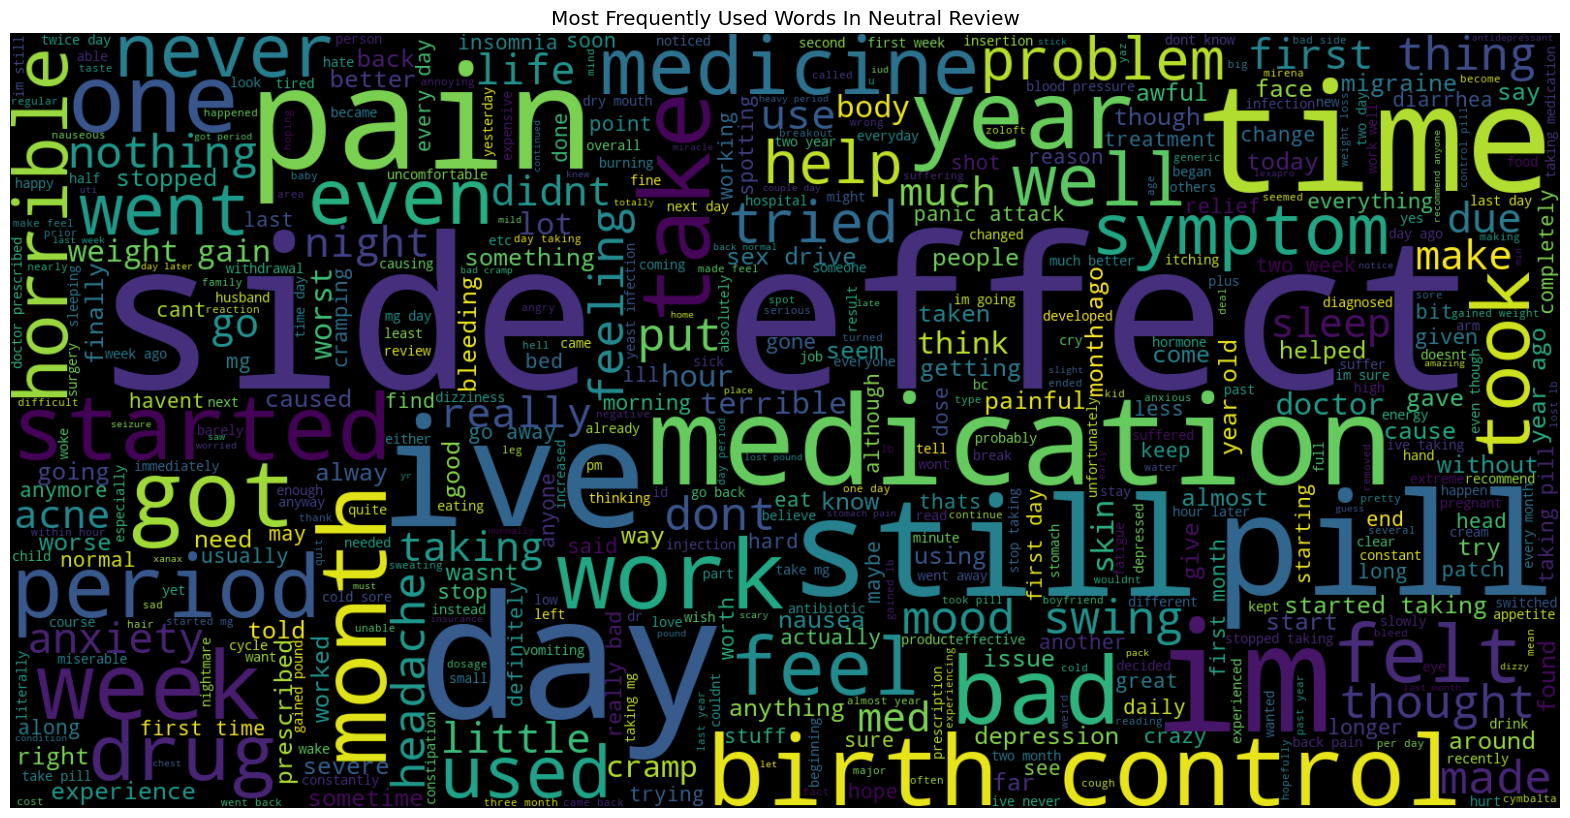

In [67]:
text = ' '.join([word for word in neu_reviews['cleaned_reviews']])
plt.figure(figsize=(20,60), facecolor=None)
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequently Used Words In Neutral Review')

Observation
- The word cloud for neutral reviews highlights "side effect," "birth," "control," "still," and "pill" as the most frequent terms, indicating a focus on side effects and birth control. Words like "medication," "time," "pain," "week," "and "month" suggest ongoing experiences with the medication. Terms such as "feel," "work," and "drug" may indicate mixed feelings about the medication's effectiveness. Overall, the neutral reviews provide a balanced view of ongoing medication experiences.

In [71]:
#TF-IDF vectorization converts text into numerical data by highlighting important words while downplaying common ones. 
#This helps the model focus on relevant features from the reviews for better prediction

# Vectorizing training data. 
tfidf = TfidfVectorizer() 
x = tfidf.fit_transform(df['cleaned_reviews'])
y = df['target']
## Applying Tf-Idf vectorizer on the Text column.

Splitting the Data for Training and Testing

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [74]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (32275, 36636)
Size of y_train: (32275,)
Size of x_test: (13833, 36636)
Size of y_test: (13833,)


**Logistic Regression**

In [76]:
# Fit Logistic Regression model
log_reg = LogisticRegression().fit(x_train, y_train)

# Predict on train
train_preds = log_reg.predict(x_train)

# Accuracy on train
print("Model accuracy on train is: ", accuracy_score(y_train, train_preds))  # Use y_train instead of x_train

# Predict on test
test_preds = log_reg.predict(x_test)

# Accuracy on test
print("Model accuracy on test is: ", accuracy_score(y_test, test_preds))

# Precision, Recall, F1 score (use 'macro' for multiclass)
precision = precision_score(y_test, test_preds, average='macro')
recall = recall_score(y_test, test_preds, average='macro')
f1 = f1_score(y_test, test_preds, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

Model accuracy on train is:  0.9132455460883037
Model accuracy on test is:  0.8612737656329068
Precision: 0.5730
Recall: 0.5669
F1 score: 0.5686


*K-Fold Cross-Validation for Logistic Regression Model*


In [77]:
k = 15

# Initialize K-Fold with the specified number of splits
kfold = KFold(n_splits=k, shuffle=True, random_state=20)

# Perform cross-validation
K_results = cross_val_score(log_reg, x, y, cv=kfold)

# Calculate the mean accuracy
accuracy = np.mean(K_results)  # Use K_results directly, not absolute values
print("Mean Cross-Validation Accuracy:", accuracy)

Mean Cross-Validation Accuracy: 0.8678317804669614


Result Explanation:
- The model performs well overall, with a 91% accuracy on the training data and 86% on new, unseen data. 
- It also does well when tested on different parts of the data, with an average accuracy of 87%. However, it’s only about 57% accurate in correctly identifying positive cases, and it sometimes misses or misclassifies them.

**Decision Tree Classifier**

In [85]:
# Fit the model on the training data only
DTree = DecisionTreeClassifier().fit(x_train, y_train)

# Predict on the test set (we avoid predicting on the training set to prevent data leakage)
test_preds2 = DTree.predict(x_test)

# Accuracy on test
print("Model accuracy on test is: ", accuracy_score(y_test, test_preds2))

# Precision, Recall, F1 score (use 'macro' for multiclass)
precision = precision_score(y_test, test_preds2, average='macro')
recall = recall_score(y_test, test_preds2, average='macro')
f1 = f1_score(y_test, test_preds2, average='macro')

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

Model accuracy on test is:  0.7646931251355454
Precision: 0.6099
Recall: 0.5876
F1 score: 0.5974


In [86]:
k = 15

# Initialize K-Fold with the specified number of splits
kfold = KFold(n_splits=k, shuffle=True, random_state=20)

# Perform cross-validation
K_results = cross_val_score(DTree, x, y, cv=kfold)

# Calculate the mean accuracy
accuracy = np.mean(K_results)  # Use K_results directly, not absolute values
print("Mean Cross-Validation Accuracy:", accuracy)

Mean Cross-Validation Accuracy: 0.7719264964586515


**Result Explanation**

- The model exhibits a reasonable performance, achieving an accuracy of 76.47% on the test data, indicating it correctly predicts about three-quarters of the instances. The mean cross-validation accuracy of 77.19% suggests that the model maintains consistent performance across different subsets of the training data. However, the precision of 60.99% implies that while the model identifies a decent portion of positive predictions correctly, it also misclassifies some negative cases as positive. The recall of 58.76% indicates that the model is missing a significant number of actual positive cases. The F1 score of 59.74% provides a balanced measure of the model’s performance, highlighting the trade-off between precision and recall.

**HyperParameter Tuning Decision tree**

In [88]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],  # Criteria for splitting
    'max_depth': [None, 5, 10, 15, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5],  # Minimum samples required to be at a leaf node
}

# Initialize the Decision Tree Classifier
DTree = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=DTree, param_grid=param_grid, 
                           scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)

# Fit the Grid Search to the training data
grid_search.fit(x_train, y_train)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Predict on the test set using the best estimator
best_model = grid_search.best_estimator_
test_preds2 = best_model.predict(x_test)

# Accuracy on test
print("Model accuracy on test is: ", accuracy_score(y_test, test_preds2))

# Precision, Recall, F1 score
precision = precision_score(y_test, test_preds2, average='macro')
recall = recall_score(y_test, test_preds2, average='macro')
f1 = f1_score(y_test, test_preds2, average='macro')

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Model accuracy on test is:  0.7628858526711487
Precision: 0.6103
Recall: 0.5892
F1 score: 0.5985


Hyperparameter Tuning Result Explanation

The hyperparameter tuning process involved fitting the model using 5-fold cross-validation across 90 different combinations of parameters, resulting in a total of 450 model fits. The best parameters identified for the Decision Tree model were:

    Criterion: 'gini' - This metric is used to measure the quality of a split, with the Gini impurity being preferred for its computational efficiency.
    Max Depth: None - Allowing the tree to expand fully, which can lead to overfitting if not controlled.
    Min Samples Leaf: 1 - This indicates that a leaf can have as few as one sample, potentially allowing for more complex trees.
    Min Samples Split: 2 - This means a node must have at least two samples to be considered for splitting.

Despite finding optimal parameters, the model's performance on the test set shows an accuracy of 76.29%, with precision at 61.03%, recall at 58.92%, and an F1 score of 59.85%. These results indicate's the model retains similar performance to its previous iteration.

**Random Forest Classifier**

In [90]:
# Fit the model on the training data only
RF = RandomForestClassifier().fit(x_train, y_train)

# Predict on train (this should use x_train, not x_test)
train_preds3 = RF.predict(x_train)

# Accuracy on train
print("Model accuracy on train is: ", accuracy_score(y_train, train_preds3))  

# Predict on test
test_preds3 = RF.predict(x_test)

# Accuracy on test
print("Model accuracy on test is: ", accuracy_score(y_test, test_preds3))

# Precision, Recall, F1 score (use 'macro' for multiclass)
precision = precision_score(y_test, test_preds3, average='macro')  
recall = recall_score(y_test, test_preds3, average='macro')  
f1 = f1_score(y_test, test_preds3, average='macro') 

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

Model accuracy on train is:  1.0
Model accuracy on test is:  0.7996096291476903
Precision: 0.8975
Recall: 0.5430
F1 score: 0.5898


In [92]:
k = 15

# Initialize K-Fold with the specified number of splits
kfold = KFold(n_splits=k, shuffle=True, random_state=20)

# Perform cross-validation
K_results = cross_val_score(RF, x, y, cv=kfold)

# Calculate the mean accuracy
accuracy = np.mean(K_results)  # Use K_results directly, not absolute values
print("Mean Cross-Validation Accuracy:", accuracy)

Mean Cross-Validation Accuracy: 0.8146525982414611


Result Explanation
- The Random Forest model achieved a perfect accuracy of 100% on the training data, indicating potential overfitting. In contrast, its accuracy on the test data is 79.96%, which, while solid, shows a significant drop. The precision of 89.75% indicates that positive predictions are mostly correct, but the recall of 54.30% reveals that many actual positive cases are missed. The F1 score of 58.98% suggests a need for improvement in capturing positive instances. The mean cross-validation accuracy of 81.47% indicates the model maintains consistent performance across different training subsets.

**Conclusion**

Through a detailed analysis of drug reviews, this project uncovered several key insights and results:

Sentiment Distribution: The sentiment analysis revealed that the majority of reviews were positive (around 63.7%), followed by negative reviews (34.9%) and a small percentage of neutral reviews (1.4%). This indicates a generally favorable sentiment towards the drugs being reviewed.

Rating Distribution: The distribution of ratings showed a strong preference for higher ratings, with the most common rating being 10, followed by 9. This suggests that most users had positive experiences with the drugs they reviewed.

Top Reviewed Drugs: Drugs like Escitalopram and Mirena received the highest number of reviews, indicating their popularity and widespread use. Other highly reviewed drugs were those used for birth control, mental health treatments, and weight loss.

Useful Count vs. Rating: The scatter plot of useful counts against ratings showed no clear correlation, suggesting that users found reviews helpful regardless of whether they rated the drug highly or poorly.

Review Length: The histogram of review lengths showed that most reviews were relatively short, with only a few lengthy reviews. This suggests that users tend to leave brief feedback, but longer reviews may contain more detailed experiences.

Sentiment Trends Over Time: An analysis of sentiments over time showed a downward trend, indicating that user opinions may have become slightly more negative or less enthusiastic in recent years.

Machine Learning Results:

- The Logistic Regression model achieved an accuracy of 86.1% on the test set, showing strong performance in predicting user sentiment. However, precision and recall were moderate, indicating challenges in correctly identifying some positive and negative cases.
- The Decision Tree model achieved 76.4% accuracy, with a lower F1 score compared to Logistic Regression, suggesting room for improvement.
- The Random Forest model showed signs of overfitting, achieving 100% accuracy on the training data but dropping to 79.9% on the test data. While - precision was high (89.75%), recall remained relatively low, indicating that many actual positive cases were missed.
- Topic Modeling: Using Latent Dirichlet Allocation (LDA), key themes were identified in the reviews, such as anxiety treatment, medication side effects, skin conditions, pain management, and birth control. These topics provide valuable insights into the primary concerns and experiences of drug users.